# Data Scientist Assignment


In this task, you will work with a sample dataset containing ad impression and click data.

The primary objective of this assignment is to analyze the data, derive meaningful insights, and build predictive models based on the patterns you uncover, to ultimatly improve click prediction.


# 0. Data Description


The dataset provided has been undersampled to ensure that clicks represent 5% of the total data, as opposed to the original 0.4%. It consists of one week of advertising data from Finland where one row represents an ad impression (view). The data includes the following features:

- Label: A binary feature indicating whether the ad was clicked (1) or not (0).
- art: The ad ID.
- loc: The site ID, representing the website where the ad appeared.
- tag: The placement ID assigned by the site to indicate the ad slot on the site where the ad was shown.
- dt: The device type on which the ad was displayed (mobile, tablet, or desktop).
- type: The type of advertisement, either banner or native.
- os: The operating system of the device.
- lt: The local time when the ad was displayed.
- make: The make (manufacturer) of the device.
- client: The client ID representing the advertiser.
- lang: The language of the browser.
- cl: The number of clicks the ad has received.


## 1. Loading the data & exploration


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import ipywidgets as widgets
from IPython.display import display

warnings.filterwarnings("ignore")

from utils import *

N = 15

# Load dataset:
df = pd.read_feather("readpeak_data.feather")
df.head()

,art,loc,tag,dt,type,os,lt,make,client,city,lang,cl,label
9037056,6cb6aadc,4be84111,95e44e1c,mobile,native,Android,2022-06-10T01:56:49.332Z,Samsung,3234052e,eb1c296c,en,72,0
1493784,d7ac4cc4,a9346b00,c138f7fa,desktop,native,None,2022-06-12T09:32:13.555Z,None,79e89163,aa56ab48,None,467,0
6637725,9c1ddd84,be4b2f45,6438275c,desktop,native,None,2022-06-07T18:04:11.615Z,None,ae8046da,0cf4e8a7,None,27,0
1781706,00b396ac,68e476b5,0ed73eeb,desktop,native,None,2022-06-08T10:04:41.808Z,None,ae8046da,None,None,519,0
17525502,426595c6,5d389f5e,21c6d6a0,mobile,native,AndroidOS,2022-06-11T13:07:09.077Z,GenericPhone,5f96ea9c,ce81d3d8,None,84,0


### 1.1. Data Cleaning


### What potential challenges can you identify from the given data? and give a brief explanation how you would address them?


Let's first remove all duplicate data. We can see that there are only 113 duplicated rows, which is very small compared to the total rows.


In [2]:
# Remove duplicates:
print(f"Number of duplicates: {df.duplicated().sum()} / {len(df)}")
df = df.drop_duplicates()

Number of duplicates: 113 / 1523340


Next we will convert datetime column **lt** to datetime type.  
For string type columns, we lowercase and strip whitespace for them.


In [3]:
# Ensure correct data types:
df["lt"] = pd.to_datetime(df["lt"].map(lambda t: t.split(".")[0]))

# Lowercase and strip whitespace all string columns:
df = df.applymap(lambda s: s.lower().strip() if type(s) == str else s)

We then normalize some of the columns. In particular:

- **os**: Similar os type such as "apple ios", "ipados", "ios" will be normalized to just "ios".
- **lang**: Language "en-us" or "sv-se" should be normalized to "en" or "sv" respectively.
- **make**: "samsungtablet" or "huaweitablet" will have "tablet" removed because this information is in **dt** column. Value like "iphone", "mac", etc will be normalized to "apple" because they are all manufactored by "apple".


In [4]:
# Normalize "os", "lang", and "make":
df["os"] = df["os"].apply(normalize_os)
df["lang"] = df["lang"].apply(normalize_lang)
df["make"] = df["make"].apply(normalize_make)

Now we will handle missing data. We first plot the percentage of missing values and value frequency distribution for each columns.


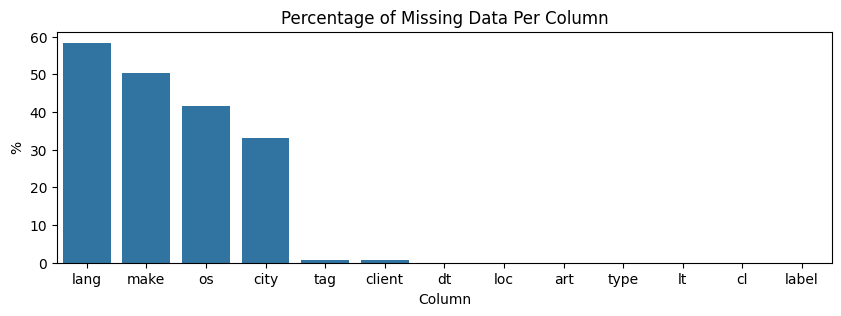

In [5]:
# Plot percentage of missing data:
missings = (df.isnull().mean() * 100).round(2).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Percentage of Missing Data Per Column")
ax.set_xlabel("Column")
ax.set_ylabel("%")
sns.barplot(x=missings.index, y=missings.values, ax=ax)
plt.show()


# Plot data distribution:
# Create tab widget
tab = widgets.Tab()
contents = []

columns = list(missings.loc[missings > 0].index)
for column in columns:
    # Create an output widget for each plot
    output = widgets.Output()

    with output:
        fig, ax = plt.subplots(figsize=(10, 3))
        sns.countplot(
            data=df,
            x=column,
            order=df[column].value_counts().nlargest(50).index,
            ax=ax,
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_title(f"{column.capitalize()} Count", fontsize=16)
        plt.show()

    # Append the output widget to the outputs list
    contents.append(output)

# Set the tab children to the list of outputs
tab.children = contents
tab.titles = columns

# Display the tab widget
display(tab)

From the plot, we can see that:

- Almost 60% of **"lang"** are missing, and it's heavily skewed to **fi**. The data are collected in Finland, so it's very likely that the missing values are mostly **fi**. There is also no information about the language of the ads, so imputing those missing values probably won't help much for the prediction -> Drop **lang** column.
- **"make"** also has large missing percentage. I believe that **os** and **dt** are closely related to **make**. Chi-Square Test for Independence can be used to check it -> Drop **make** column.
- **"os"**, **"city"**, **"client"**, **"tag"** missing values will be imputed with **unknown**.


In [6]:
# Drop "lang" column:
df = df.drop(["lang", "make"], axis=1)

# Impute missing values with "unknown":
df = df.fillna("unknown")

In [7]:
# Reset index:
df.reset_index(drop=True, inplace=True)

### 1.2 Exploratory Data Analysis


#### 1.2.1 Total Impressions vs CTR
Let's first understand the relationship between the number of impressions of each category and Click Through Rate (% CTR). From the visualization we can see that:

- CTRs of categories of **art**, **loc**, **tag**, **client** vary significantly. Some of them even go up to 20%, which might indicate that they are:
  - **loc**: site that is very good at showing ads
  - **tag**: page that goes very well with ads
  - **client**: client that has several successful campaigns
  - **art**: ads that is very attractive and performant
- CTRs of **dt**, **type**, **os**, **city** doesn't seem to vary much. Those of **city** are even plateau. This might indicate that these columns are not strong predictors for CTR.

**Note**: I believe the given data contains only impression that Readpeak bidded successfully. This is not the actually the total impressions that hit Readpeak's system. Won impressions can still be a good proxy of the total incoming impressions though.

**CTR Calculation**: I calculate CTR by posterior mean of a binomial distribution with beta prior $Beta(\alpha, \beta)$. Given the CTR is usually around 0.4%, the formula is:

$$
CTR = 100 * \frac{\alpha + clicks}{\alpha + \beta + impressions}, where \{^{\alpha = 4}_{\beta = 996}
$$


In [8]:
from utils import *

columns = list(df.drop(["lt", "label", "cl"], axis=1).columns)

# Create tab widget
tab = widgets.Tab()
contents = []

for i, column in enumerate(columns):
    fig = plot_category_vs_ctr(df, column, 50)
    output = widgets.Output()
    with output:
        display(fig)
    contents.append(output)

# Set the tab children to the list of outputs
tab.children = contents
tab.titles = columns

# Display the tab widget
display(widgets.VBox([widgets.HTML(value="<h1>Total Impressions vs CTR</h1>"), tab]))

#### 1.2.2 Sites-Placements Impressions & CTR Through Time
Next let's visualize how the impressions and CTR of sites **loc**, and ads placement **tag** change over time.
- From the plot, we can see clear seasonal trends in the amount of impressions and CTR from the site and placement.
- For a given ads placement, there might be multiple peaks of impression during a day, but CTR tends to be **higher at the first peak**. Maybe readers click on ads when they first see it, and then don't click when they see it again.
- There are more impressions at certain hours than others, especially from 6AM to 12AM. Maybe these sites are newspapers.
- Sites like **85daaf6f** and **80c3cd40** even though doesn't have a lot of impressions, it has really high cumulative CTR.
- Whether a day is weekday or weekend doesn't seem to affect the amount of impressions and CTR.
- Site **d6d824ab** is mostly read by **Windows** users. This is interesting and might indicate that **os** can be a good feature. 

From there, I believe that hour of the day, hourly/cumulative impressions/CTR in that hour can be additional features because they inform about the amount of traffic a site or placement receives at a particular time.

In [9]:
from utils import *

# Create a tab widget
tab = widgets.Tab()
tab_contents = []

# # Loop through each 'loc' id and create a tab for each one
loc_ids = select_for_plot(df, "loc", N)
for loc_id in loc_ids:
    loc_content = create_content(df, {"loc": loc_id})

    # Create a 'tag' tab for each loc id
    tag_tab = widgets.Tab()
    tag_contents = []

    tag_ids = select_for_plot(filter_df(df, {"loc": loc_id}), "tag", N)
    for tag_id in tag_ids:
        tag_content = create_content(df, {"loc": loc_id, "tag": tag_id})
        tag_contents.append(tag_content)
    tag_tab.children = tag_contents
    tag_tab.titles = tag_ids

    # Add the layout to the tab contents
    tab_contents.append(
        widgets.VBox(
            [
                loc_content,
                widgets.HTML(value="<h2>Ads Placement vs CTR</h2>"),
                tag_tab,
            ]
        )
    )

# # Set up the tabs in the widget
tab.children = tab_contents
tab.titles = loc_ids

# Display the tab widget
display(widgets.VBox([widgets.HTML(value="<h1>Site vs CTR</h1>"), tab]))

#### 1.2.3 Client-Ads Impressions & CTR Through Time
Next let's visualize how the impressions and CTR of client **client**, and ads **art** change over time.
- Clients like **53060964** and **9f729681** have ads run very effectively with high CTR, and run specifically in the early morning. 
- Similar pattern that first impression peak having higher CTR can also be seen with clients **79e89163** and **de85fa72**

In [10]:
from utils import *

# Create a tab widget
tab = widgets.Tab()
tab_contents = []

# Loop through each 'client' id and create a tab for each one
client_ids = select_for_plot(df, "client", N)
for client_id in client_ids:
    client_content = create_content(df, {"client": client_id})

    # Create a 'art' tab for each loc id
    art_tab = widgets.Tab()
    art_contents = []

    art_ids = select_for_plot(filter_df(df, {"client": client_id}), "art", N)
    for art_id in art_ids:
        art_content = create_content(df, {"client": client_id, "art": art_id})
        art_contents.append(art_content)
    art_tab.children = art_contents
    art_tab.titles = list(art_ids)

    # Add the layout to the tab contents
    tab_contents.append(
        widgets.VBox(
            [
                client_content,
                widgets.HTML(value="<h2>Ads vs CTR</h2>"),
                art_tab,
            ]
        )
    )

# Set up the tabs in the widget
tab.children = tab_contents
tab.titles = client_ids

# Display the tab widget
display(widgets.VBox([widgets.HTML(value="<h1>Client vs CTR</h1>"), tab]))

#### 1.2.4 Placement-Ads Pair Impressions & CTR Through Time
Next let's visualize how the impressions and CTR of placement-ads pair change over time.
- Pairs like **749cb784-78191029** and **0719d15d-67cc5d01** have high CTR, but their CTRs slightly decrease over time. This might indicate that people are less likely to click on the same ads displayed in the same place if they have seen it before.
- Some pairs seem to perform consistently whenever the ads are displayed in the same place.

In [14]:
from utils import *

# Create a tab widget
tab = widgets.Tab()
tab_contents = []

# Loop through each 'client' id and create a tab for each one
df["match"] = df["tag"] + "-" + df["art"]
match_ids = select_for_plot(df, "match", N)
for match_id in match_ids:
    # Add the layout to the tab contents
    tab_contents.append(create_content(df, {"match": match_id}))

# Set up the tabs in the widget
tab.children = tab_contents
tab.titles = match_ids

# Display the tab widget
display(widgets.VBox([widgets.HTML(value="<h1>Placement-Ads Pair vs CTR</h1>"), tab]))

# 2. Feature Engineering


### Create at least two new features from the existing data.


From the above analysis, some notable features that worth adding to support click prediction are:

- **cac**:
- **lon**:
- **cu**:


#### What new features did you create and why?


#### How do you expect these features to improve the performance of a machine learning model?


#### What kind of external data could be used to improve the predictive performance of the ML model?


# Model selection and building


### The goal of the model is to predict the likelyhood of a click


##### Choose at least two different ML models to fit to the data.


In [12]:
# write your code here

#### Why did you select these models? What assumptions or characteristics of the dataset influenced your choice?


### Given the advertising ecosystem, speed of prediction is crucial. How would you change the selected models with this restraint in mind? Explain your reasoning.
